# import libraries

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyaw.swarm import save_SW_EFIx_TCT16, save_SW_MAGx_HR_1B
import utils

# basic assignment of variables

In [2]:
analytical_start_time = '20160311T064700'
analytical_end_time = '20160311T064900'
# QA:: extend one window time (in this reproduction, the window time will be 20 seconds)
start_time = '20160311T064640'
end_time = '20160311T064920'
satellite = 'A'
sdir = Path("./data")
sfn_EFIA_TCT16 = Path("EFIA_TCT16_20160311T064640_20160311T064920.pkl")
sfn_MAGA_HR_1B = Path("MAGA_HR_1B_20160311T064640_20160311T064920.pkl")
fs_e = 16
fs_b = 50

# download data

In [3]:
save_SW_EFIx_TCT16(start_time, end_time, satellite, sdir,
                   sfn_EFIA_TCT16)
save_SW_MAGx_HR_1B(start_time, end_time, satellite, sdir,
                   sfn_MAGA_HR_1B)

data\EFIA_TCT16_20160311T064640_20160311T064920.pkl already exists, skip save.
data\MAGA_HR_1B_20160311T064640_20160311T064920.pkl already exists, skip save.


# read data

In [4]:
df_e = pd.read_pickle(Path(sdir) / Path(sfn_EFIA_TCT16))
df_b = pd.read_pickle(Path(sdir) / Path(sfn_MAGA_HR_1B))
timestamps_e = df_e.index.values
timestamps_b = df_b.index.values
del sdir,sfn_EFIA_TCT16,sfn_MAGA_HR_1B

# magnetic field in NEC coordinate system

In [5]:
bn,be,bc = utils.get_3arrays(df_b['B_NEC'].values)

## plot

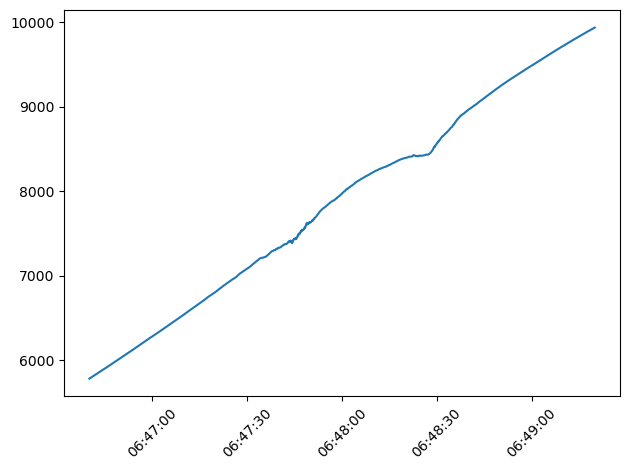

In [6]:
plt.plot(timestamps_b, bn)  # todo:: add latitude and so on information to the plot on x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

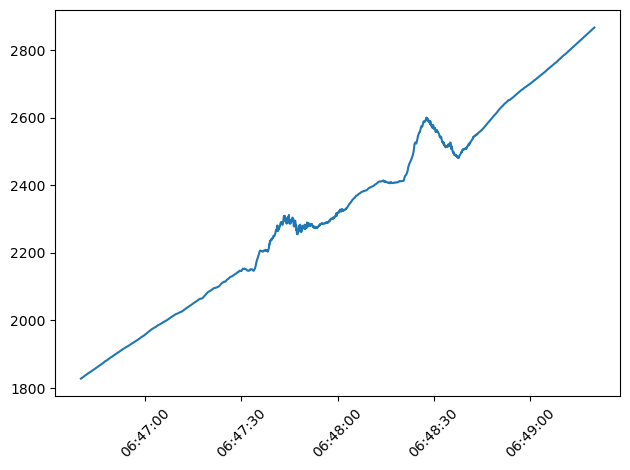

In [7]:
plt.plot(timestamps_b, be)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

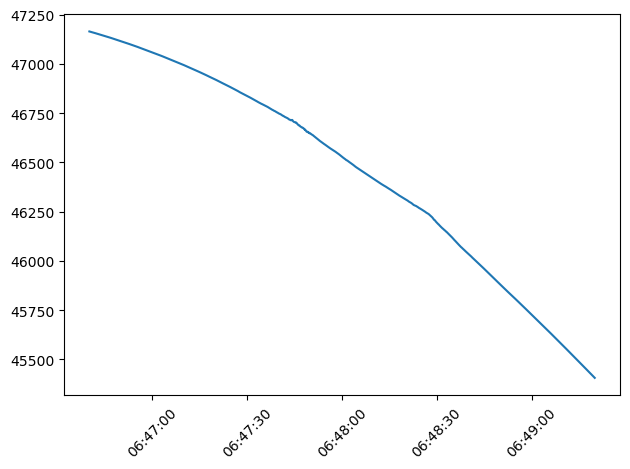

In [8]:
plt.plot(timestamps_b, bc)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# electric field in NEC coordinate system

## electric field in satellite-track coordinate system

In [9]:
Ehx = df_e['Ehx'].values
Ehy = df_e['Ehy'].values

## coordinate transformation from satellite-track coordinate system to NEC coordinate system

In [10]:
VsatN = df_e['VsatN'].values
VsatE = df_e['VsatE'].values
rotation_matrix_2d_nec2sc,rotation_matrix_2d_sc2nec = utils.get_rotation_matrices_nec2sc_sc2nec(VsatN,VsatE)

### preprocess before rotation

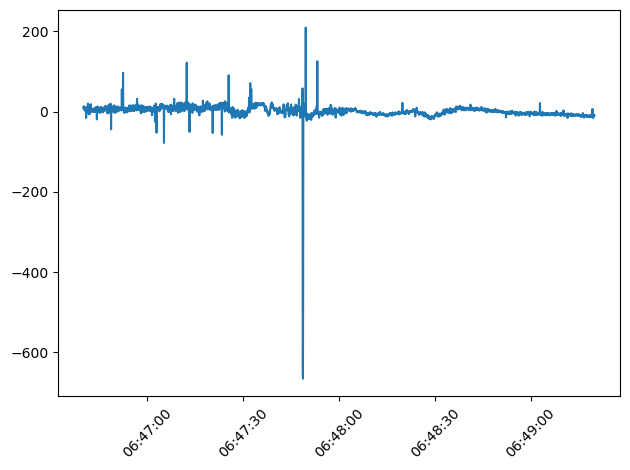

In [11]:
plt.plot(timestamps_e, Ehx)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

In [12]:
np.std(Ehx),np.mean(Ehx),np.max(Ehx),np.min(Ehx)

(23.041916, 1.0366622, 209.64946, -665.1797)

In [13]:
Ehx_set_outliers_nan = utils.set_outliers_nan(Ehx,print_=True)
Ehy_set_outliers_nan = utils.set_outliers_nan(Ehy,print_=True)

30
[ -43.9735     55.85131    96.95131    31.929352  -25.18946   -52.246895
  -77.74769    32.06451   122.04997    24.538439  -50.420204   27.311708
   25.95723   -52.979156  -57.540714   24.142708   25.899548   90.70911
   35.12801    71.15288    56.372738   31.657372   27.904247   58.08169
 -630.02313  -665.1797   -455.31207   209.64946   -22.509426  125.68604 ]
33
[  64.18146    69.17008    68.854675   67.748085   72.29167    63.576897
   71.010735   70.199295   79.56611    62.859295   72.29569    68.10827
   68.18476    65.32831    85.93454    71.88532    65.98927    62.882183
   71.72013    65.072205   68.92534    64.02373    63.6884     63.51877
   71.33222   -65.169945 1116.1362   1207.5975    117.2339     88.194145
   63.17441   -23.732807   -8.277935]


In [14]:
Ehx_set_outliers_nan_interpolated = utils.get_array_interpolated(timestamps_e, Ehx_set_outliers_nan)
Ehy_set_outliers_nan_interpolated = utils.get_array_interpolated(timestamps_e, Ehy_set_outliers_nan)

### do rotation

In [15]:
Ehn,Ehe = utils.do_rotation(-Ehx_set_outliers_nan_interpolated, -Ehy_set_outliers_nan_interpolated, rotation_matrix_2d_sc2nec)
# note:: I add the negative sign to the x,y components of the electric field in the satellite-track coordinate system.

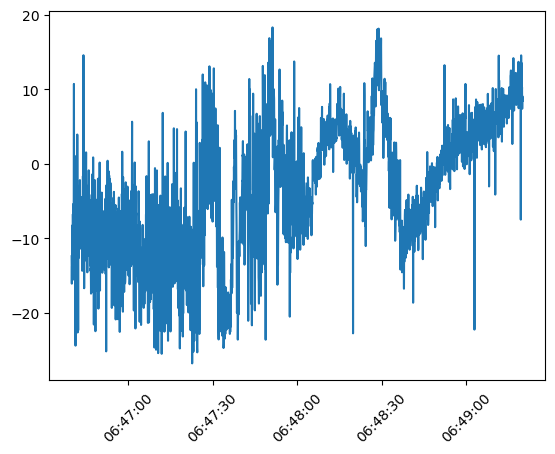

In [16]:
plt.plot(timestamps_e, Ehn)
plt.xticks(rotation=45)
plt.show()

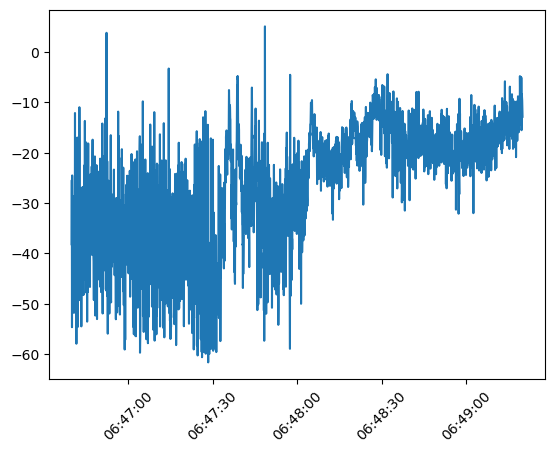

In [17]:
plt.plot(timestamps_e, Ehe)
plt.xticks(rotation=45)
plt.show()

# E north and B east

## original E and B

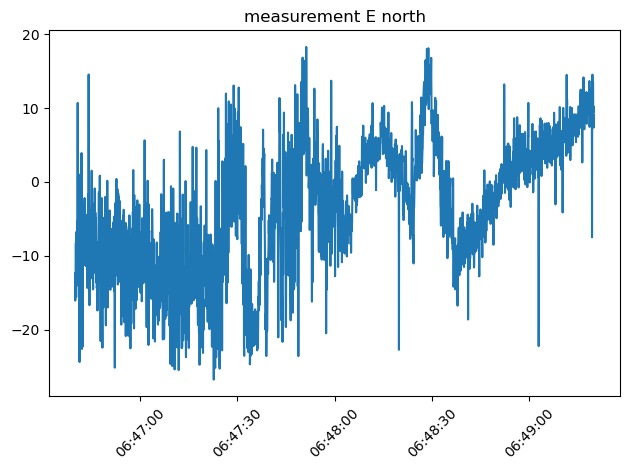

In [18]:
plt.plot(timestamps_e, Ehn)
plt.title("measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

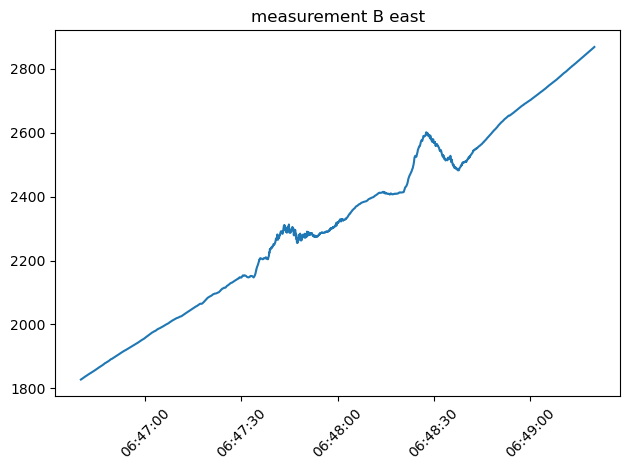

In [19]:
plt.plot(timestamps_b, be)
plt.title("measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## move average

In [20]:
mv_window_seconds = 20  # int
window_e = fs_e*mv_window_seconds
Ehn_mov_ave = utils.move_average(Ehn, window_e)

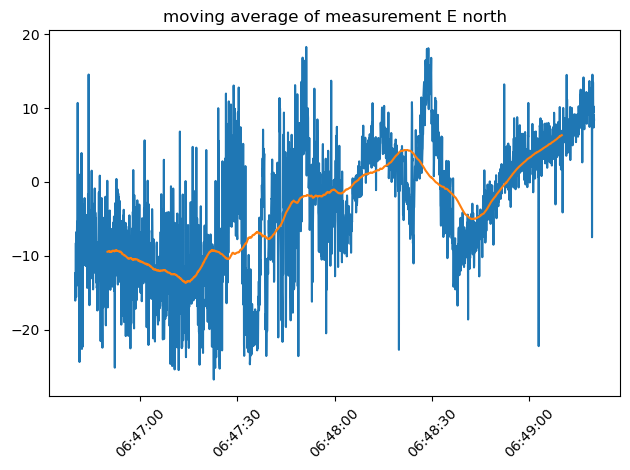

In [21]:
plt.plot(timestamps_e, Ehn)
plt.plot(timestamps_e, Ehn_mov_ave)
plt.title("moving average of measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
window_b = fs_b*mv_window_seconds
be_mov_ave = utils.move_average(be, window_b)

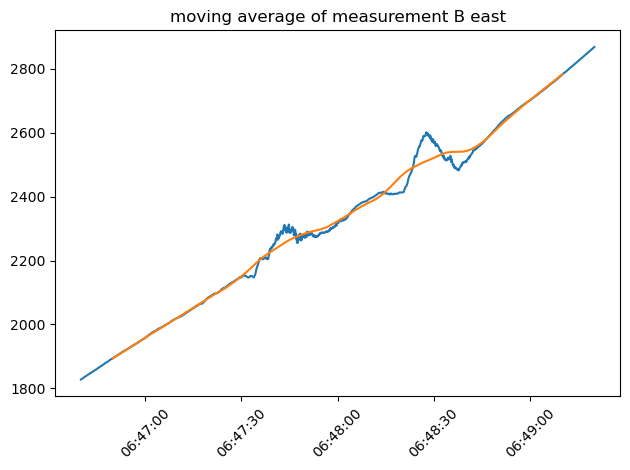

In [23]:
# plt.figure()
plt.plot(timestamps_b, be)
plt.plot(timestamps_b, be_mov_ave)
plt.title("moving average of measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(f'before and after moving average comparison')

## disturb field

delete the moving average of the field

In [24]:
Ehn_disturb = Ehn - Ehn_mov_ave
be_disturb = be - be_mov_ave

#### use analytical time to slice the disturb field

In [25]:
mask_e = np.where((timestamps_e >= utils.transform_time_string_to_datetime64ns(analytical_start_time)) & (timestamps_e <= utils.transform_time_string_to_datetime64ns(analytical_end_time)))  # mask for analytical time
mask_e

(array([ 320,  321,  322, ..., 2237, 2238, 2239], dtype=int64),)

In [26]:
analytical_timestamps_e = timestamps_e[mask_e]
analytical_Ehn_disturb = Ehn_disturb[mask_e]

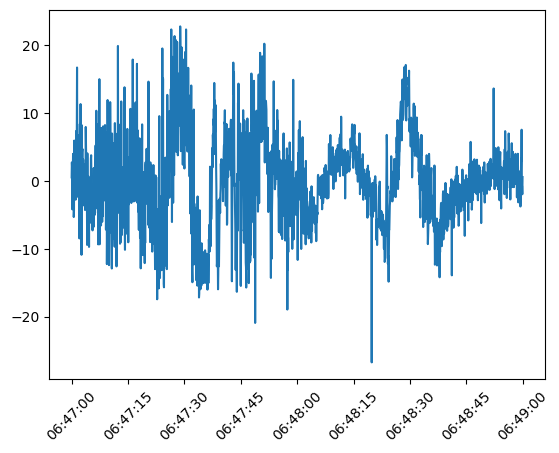

In [27]:
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb)
plt.xticks(rotation=45)
plt.show()

In [28]:
mask_b = np.where((timestamps_b >= utils.transform_time_string_to_datetime64ns(analytical_start_time)) & (timestamps_b <= utils.transform_time_string_to_datetime64ns(analytical_end_time)))  # mask for analytical time
mask_b

(array([1000, 1001, 1002, ..., 6997, 6998, 6999], dtype=int64),)

In [29]:
analytical_timestamps_b = timestamps_b[mask_b]
analytical_be_disturb = be_disturb[mask_b]

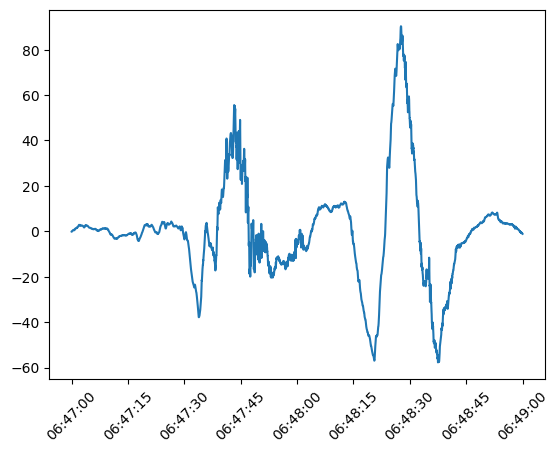

In [30]:
plt.plot(analytical_timestamps_b,analytical_be_disturb)
plt.xticks(rotation=45)
plt.show()

## filter

In [31]:
# IIR filter
lowcut=0.2
highcut=4
order=5
# get filter data
analytical_Ehn_disturb_filtered = utils.get_butter_filter(analytical_Ehn_disturb,fs_e,lowcut,highcut,order)
analytical_be_disturb_filtered = utils.get_butter_filter(analytical_be_disturb,fs_b,lowcut,highcut,order)

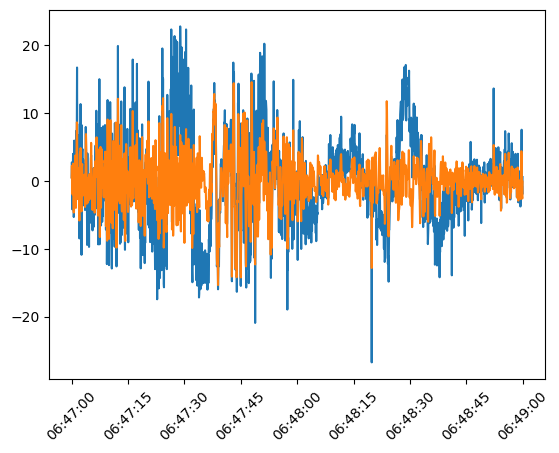

In [32]:
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb)
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb_filtered)
plt.xticks(rotation=45)
plt.show()

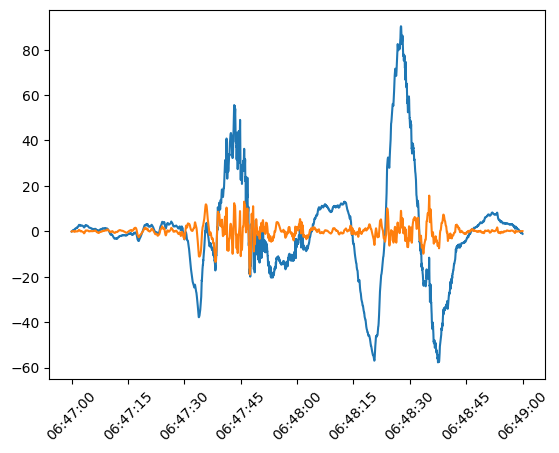

In [33]:
plt.plot(analytical_timestamps_b,analytical_be_disturb)
plt.plot(analytical_timestamps_b,analytical_be_disturb_filtered)
plt.xticks(rotation=45)
plt.show()

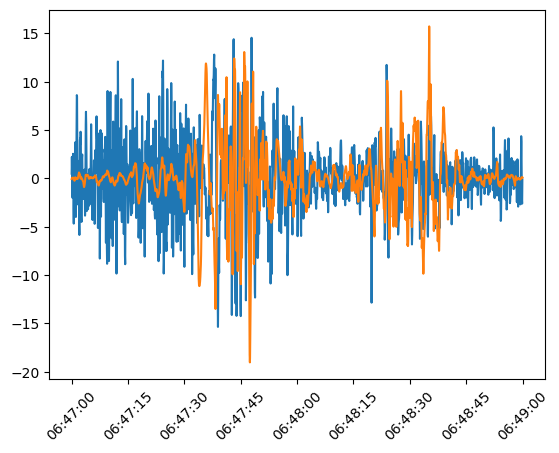

In [34]:
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb_filtered)
plt.plot(analytical_timestamps_b,analytical_be_disturb_filtered)
plt.xticks(rotation=45)
plt.show()

## STFT

short-time Fourier transform

In [35]:
from scipy.signal import stft

# stft (spectral) basic parameters
window='hann'
stft_window_seconds=4  # second
nperseg_e = int(stft_window_seconds * fs_e)  # 每个窗的采样点数
noverlap_e = nperseg_e // 2  # 50%重叠
nperseg_b = int(stft_window_seconds * fs_b)
noverlap_b = nperseg_b // 2

# get stft
f_e, t_e, Zxx_e = stft(analytical_Ehn_disturb, fs_e, window=window, nperseg=nperseg_e, noverlap=noverlap_e,scaling='psd')
f_b, t_b, Zxx_b = stft(analytical_be_disturb, fs_b, window=window, nperseg=nperseg_b, noverlap=noverlap_b,scaling='psd')

In [36]:
t_e_dt64 = analytical_timestamps_e[0] + [np.timedelta64(int(_),'s') for _ in t_e]
t_b_dt64 = analytical_timestamps_b[0] + [np.timedelta64(int(_),'s') for _ in t_b]

### module

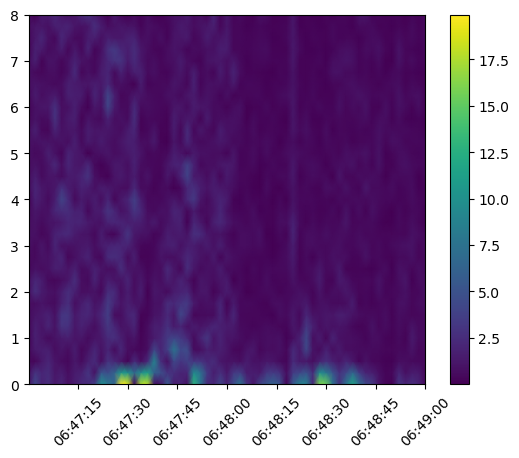

In [37]:
plt.pcolormesh(t_e_dt64, f_e, np.abs(Zxx_e), shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

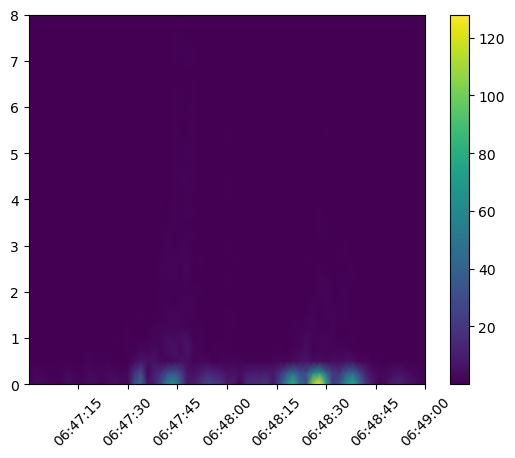

In [38]:
plt.pcolormesh(t_b_dt64, f_b, np.abs(Zxx_b), shading='gouraud')
plt.ylim([0,8])
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

### cross spectral

In [39]:
mask_f_b = np.where(f_b <= 8.0)
mask_f_b

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
       dtype=int64),)

In [40]:
f_b_mask = f_b[mask_f_b]
f_b_mask,f_e

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ]))

In [41]:
Zxx_b_mask = Zxx_b[mask_f_b]
Zxx_b_mask.shape

(33, 61)

In [42]:
# confirm
np.all(t_e==t_b),np.all(t_e_dt64==t_b_dt64),np.all(f_e==f_b_mask),Zxx_b_mask.shape==Zxx_e.shape
# note:: because the fs between b and e is different, so the start time of b and e is fine different

(True, False, True, True)

In [43]:
cross_e_b_spectral_density = Zxx_e * np.conj(Zxx_b_mask)

#### module

In [44]:
cross_e_b_spectral_density_module = np.abs(cross_e_b_spectral_density)
np.min(cross_e_b_spectral_density_module),np.max(cross_e_b_spectral_density_module),np.percentile(cross_e_b_spectral_density_module,95)

(3.4459414148942276e-05, 2056.7596666950794, 9.607242127605579)

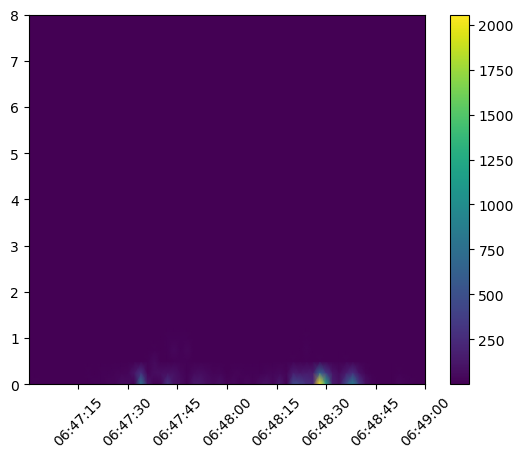

In [45]:
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_module, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

##### process the outliers

In [46]:
threshold = np.percentile(cross_e_b_spectral_density_module,95)  # note:: use 95% percentile not the maximum value
set_value = np.min(cross_e_b_spectral_density_module)

modified_cross_e_b_spectral_density_module = utils.threshold_and_set(cross_e_b_spectral_density_module.copy(), threshold, set_value) # Use .copy() to avoid in-place modification

In [47]:
np.min(modified_cross_e_b_spectral_density_module),np.max(modified_cross_e_b_spectral_density_module)

(3.4459414148942276e-05, 9.237798066583725)

##### normalized

In [48]:
normalized_modified_cross_e_b_spectral_density_module = utils.normalize_to_01(modified_cross_e_b_spectral_density_module)
np.min(normalized_modified_cross_e_b_spectral_density_module),np.max(normalized_modified_cross_e_b_spectral_density_module),np.percentile(normalized_modified_cross_e_b_spectral_density_module,50)

(0.0, 1.0, 0.003468215899031518)

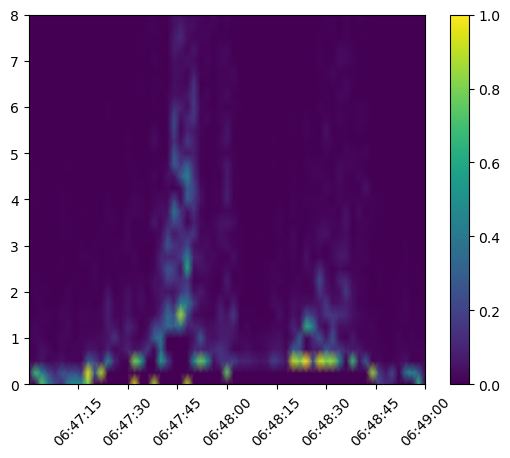

In [49]:
plt.pcolormesh(t_e_dt64, f_e, normalized_modified_cross_e_b_spectral_density_module, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

#### phase

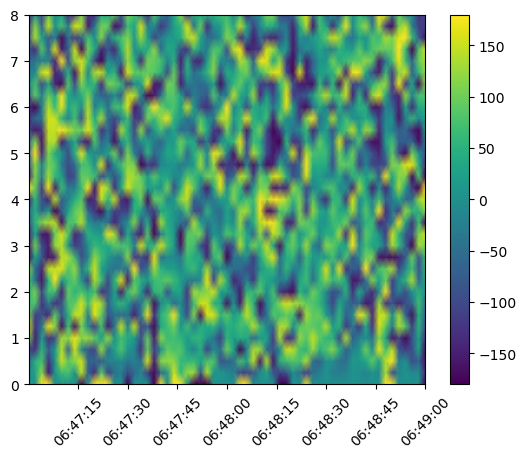

In [50]:
cross_e_b_spectral_density_phase = np.degrees(np.angle(cross_e_b_spectral_density))
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_phase, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()  # 交叉谱中很多由于数据本身的噪声的影响，导致相位图像没有规律

##### phase with threshold

In [51]:
cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase.copy()
cross_e_b_spectral_density_phase_mask[normalized_modified_cross_e_b_spectral_density_module<0.003] = np.nan
# note:: the threshold is set to 0.003 according to the 50 percentile of the normalized cross spectral density module

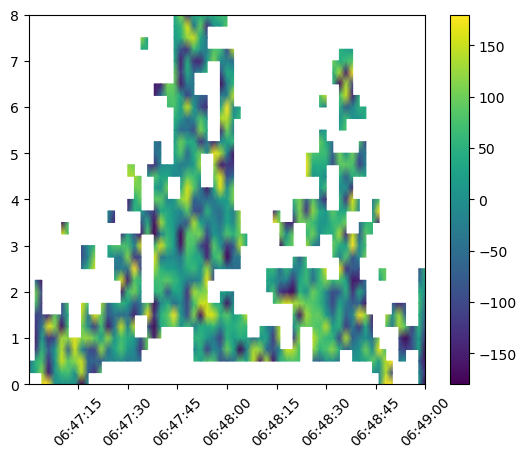

In [52]:
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_phase_mask, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

# regions

## auroral region

In [53]:
auroral_region_start_time = np.datetime64('2016-03-11T06:47:35','ns')
auroral_region_end_time = np.datetime64('2016-03-11T06:47:55','ns')  # note:: the time of auroral region is 20 seconds, that is the same as the moving average window time

In [54]:
auroral_mask = (t_b_dt64 >= auroral_region_start_time) & (t_b_dt64 <= auroral_region_end_time)
auroral_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [55]:
auroral_t_b_dt64 = t_b_dt64[auroral_mask]
auroral_Zxx_b = Zxx_b_mask[:,auroral_mask]
auroral_t_e_dt64 = t_e_dt64[auroral_mask]
auroral_Zxx_e = Zxx_e[:,auroral_mask]

### ratio

In [56]:
auroral_e_b_ratio = np.abs(auroral_Zxx_e) / np.abs(auroral_Zxx_b)
np.max(auroral_e_b_ratio),np.min(auroral_e_b_ratio),np.percentile(auroral_e_b_ratio,95)  # QA:: 一个异常值（最大值）

(2826.2025486242374, 0.025330805068584827, 16.268193122220392)

In [57]:
threshold = np.percentile(auroral_e_b_ratio,95)
set_value = threshold
modified_auroral_e_b_ratio = utils.threshold_and_set(auroral_e_b_ratio.copy(), threshold, set_value)

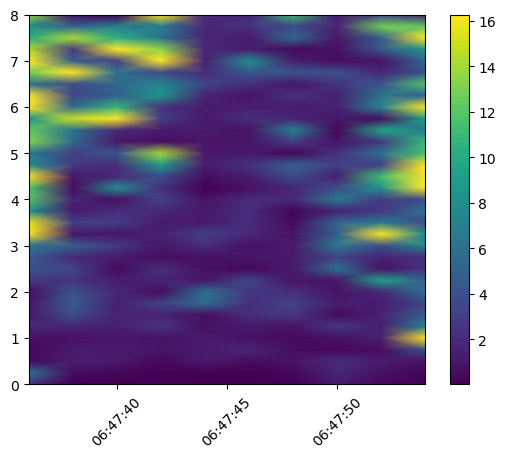

In [58]:
plt.pcolormesh(auroral_t_e_dt64, f_e, modified_auroral_e_b_ratio, shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### counts

In [59]:
np.min(modified_auroral_e_b_ratio),np.max(modified_auroral_e_b_ratio),np.percentile(modified_auroral_e_b_ratio,50),np.percentile(modified_auroral_e_b_ratio,95)

(0.025330805068584827,
 16.268193122220392,
 2.1225605344966265,
 16.10635589265272)

In [60]:
# ratio_bins = np.linspace(0,np.max(modified_auroral_e_b_ratio),num)
# note:: not use above code to generate the bins, because don't know how to set a reasonable 'num'. 如果num设置小了，对于quiet的ratio来说，可能由于部分的大值导致bins的宽度过大，从而导致计数不合理

In [61]:
auroral_ratio_bins = np.arange(0,np.max(modified_auroral_e_b_ratio)+2,2)
auroral_ratio_bins

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

In [62]:
auroral_ratio_hist_counts = utils.get_ratio_hist_counts(f_e,modified_auroral_e_b_ratio,auroral_ratio_bins)

# hist_counts = np.zeros((len(f_e),len(auroral_ratio_bins)-1))
# for i,_ in enumerate(f_e):
#     hist_counts[i],_ = np.histogram(modified_auroral_e_b_ratio[i],bins=auroral_ratio_bins)

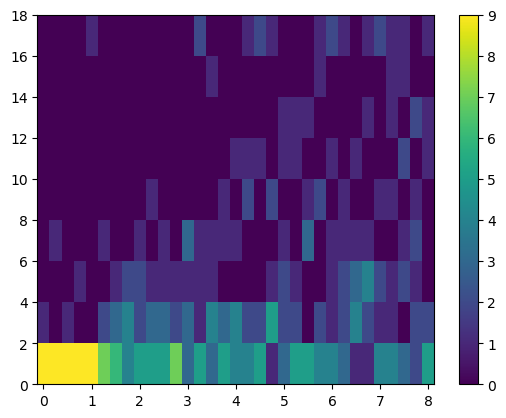

In [63]:
plt.pcolormesh(f_e,(auroral_ratio_bins[:-1]+auroral_ratio_bins[1:])/2,auroral_ratio_hist_counts.T)
plt.colorbar()
plt.show()  # todo:: 一个频率带内的比值的均值

### phase difference

with threshold

In [64]:
auroral_cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase_mask[:,auroral_mask]

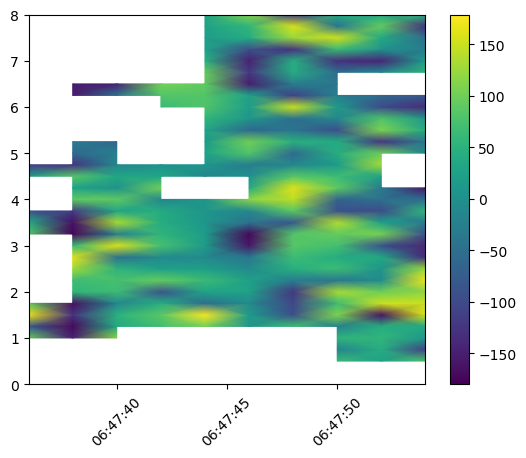

In [65]:
plt.pcolormesh(auroral_t_e_dt64,f_e,auroral_cross_e_b_spectral_density_phase_mask,shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### phase counts

In [66]:
num_bins = 50
phase_diff_bins,auroral_phase_diff_hist_counts = utils.get_phase_diff_hist_counts(f_e,auroral_cross_e_b_spectral_density_phase_mask,num_bins=num_bins)

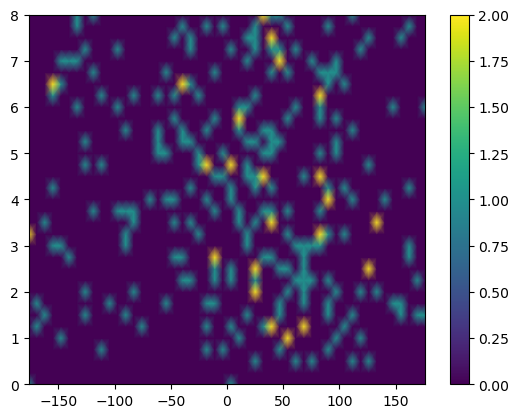

In [67]:
plt.pcolormesh((phase_diff_bins[:-1]+phase_diff_bins[1:])/2,f_e,auroral_phase_diff_hist_counts,shading='gouraud')
plt.colorbar()
plt.show()  # 看不出明显的规律。同quiet区域对比而言有一点区别，但也看不出。
# todo:: 使用 CWT 试试

## quiet

In [68]:
quiet_region_start_time = np.datetime64('2016-03-11T06:47:05','ns')
quiet_region_end_time = np.datetime64('2016-03-11T06:47:25','ns')

In [69]:
quiet_mask = (t_b_dt64 >= quiet_region_start_time) & (t_b_dt64 <= quiet_region_end_time)
quiet_mask

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [70]:
quiet_t_b_dt64 = t_b_dt64[quiet_mask]
quiet_Zxx_b = Zxx_b_mask[:,quiet_mask]
quiet_t_e_dt64 = t_e_dt64[quiet_mask]
quiet_Zxx_e = Zxx_e[:,quiet_mask]

### ratio

In [71]:
quiet_e_b_ratio = np.abs(quiet_Zxx_e) / np.abs(quiet_Zxx_b)
np.max(quiet_e_b_ratio),np.min(quiet_e_b_ratio),np.percentile(quiet_e_b_ratio,95)

(2212.3737587550695, 0.20998303735288681, 502.51564127120804)

In [72]:
threshold = np.percentile(quiet_e_b_ratio,95)
set_value = threshold
modified_quiet_e_b_ratio = utils.threshold_and_set(quiet_e_b_ratio.copy(), threshold, set_value)

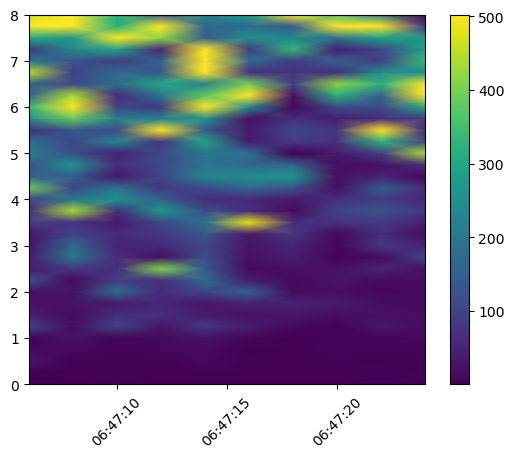

In [73]:
plt.pcolormesh(quiet_t_e_dt64, f_e, modified_quiet_e_b_ratio, shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### counts

In [74]:
np.min(modified_quiet_e_b_ratio),np.max(modified_quiet_e_b_ratio),np.percentile(modified_quiet_e_b_ratio,50),np.percentile(modified_quiet_e_b_ratio,95)

(0.20998303735288681, 502.51564127120804, 78.85964346218798, 502.5114304437966)

In [75]:
quiet_ratio_bins = np.arange(0,np.max(modified_quiet_e_b_ratio)+2,2)
quiet_ratio_bins

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284.,
       286., 288., 290., 292., 294., 296., 298., 30

In [76]:
quiet_ratio_hist_counts = utils.get_ratio_hist_counts(f_e,modified_quiet_e_b_ratio,quiet_ratio_bins)

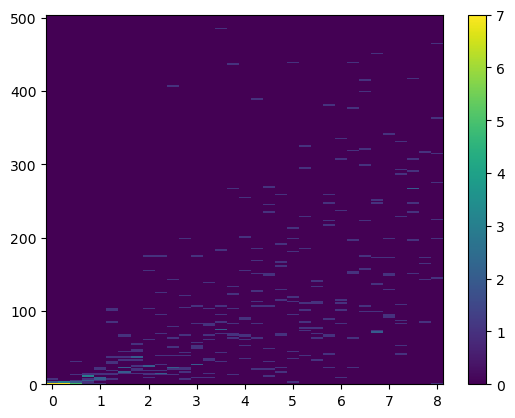

In [77]:
plt.pcolormesh(f_e,(quiet_ratio_bins[:-1]+quiet_ratio_bins[1:])/2,quiet_ratio_hist_counts.T)
plt.colorbar()
plt.show()  # todo:: 一个频率带内的比值的均值

### phase difference

In [78]:
quiet_cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase_mask[:,quiet_mask]

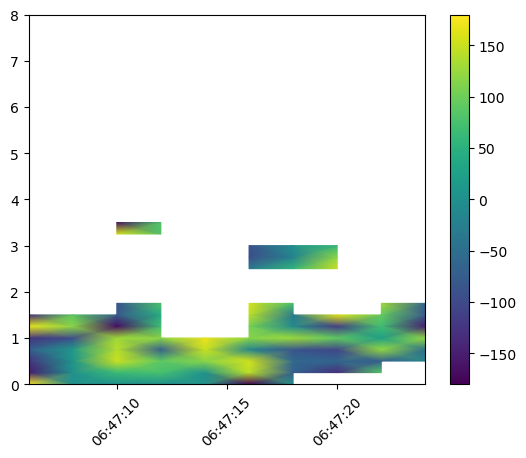

In [79]:
plt.pcolormesh(quiet_t_e_dt64,f_e,quiet_cross_e_b_spectral_density_phase_mask,shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### phase counts

In [80]:
num_bins = 50
phase_diff_bins,quiet_phase_diff_hist_counts = utils.get_phase_diff_hist_counts(f_e,quiet_cross_e_b_spectral_density_phase_mask,num_bins=num_bins)

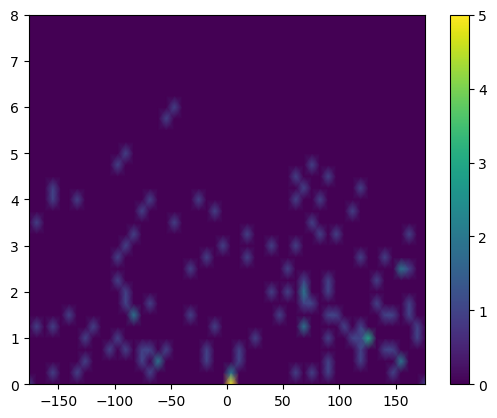

In [81]:
plt.pcolormesh((phase_diff_bins[:-1]+phase_diff_bins[1:])/2,f_e,quiet_phase_diff_hist_counts,shading='gouraud')
plt.colorbar()
plt.show()

# down-resample the MAGx_HR_1B data (50hz)

- 1b 算法文档中提到 vfm 有截止频率大约 9hz？(Swarm Level 1b Processor Algorithms. pdf, page20). so when down-resampling the MAGx_HR_1B magnetic field data to 16hz, don't firstly filter the data?